In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture # for GMM clustering
from sklearn import metrics # for calculating Silhouette score
from collections import Counter
from scipy.stats import norm

In [123]:
# Read in CSV file

df = pd.read_csv('plate9290_RVs.csv').drop(['Unnamed: 0', 'Plate ID'], axis=1)

In [124]:
# Read in CSV file

mp_df = pd.read_csv('multiplate_RVs.csv').drop(['Unnamed: 0', 'Plate ID'], axis=1)

In [125]:
df = df.sort_values(['Target ID'], ascending=True)

In [126]:
mp_df

,Target ID,MJD,OBSVHELIO (km/s),OBSVREL Error (km/s)
0,apo25m.5226.150-08-RV.2M03252400+4614203,57706,-86.565704,0.010245
1,apo25m.5226.150-08-RV.2M03252400+4614203,57732,-86.383430,0.008206
2,apo25m.5226.150-08-RV.2M03252400+4614203,57734,-86.386870,0.009015
3,apo25m.5226.150-08-RV.2M03252400+4614203,57735,-86.532840,0.010742
4,apo25m.5226.150-08-RV.2M03252400+4614203,57760,-86.366640,0.012035
...,...,...,...,...
10664,apo25m.5118.URMINOR.2M15260674+6734563,57879,0.493465,0.061337
10665,apo25m.5118.URMINOR.2M15260674+6734563,57886,0.285309,0.083303
10666,apo25m.5118.URMINOR.2M15260674+6734563,57887,0.420483,0.067660
10667,apo25m.5118.URMINOR.2M15260674+6734563,57916,0.399855,0.066620


## Step 1
- Calculate ΔRV_j = RV_j - < RV >
- Plot ΔRV vs MJD, try to locate pattern

#### Notes
- j denotes epoch (MJD?)
- 'epoch', an arbitrarily fixed date relative to which stellar/planetary measurements are expressed

#### Questions
- Does it matter that uncertainty is for OBSVREL not OBSVHELIO? --> no

In [127]:
# Identify list of unique targets

unique_targets = Counter(mp_df['Target ID'])
unique_targets_list = unique_targets.keys()

In [128]:
# unique_targets

In [129]:
len(unique_targets)

793

In [130]:
# Create list of RV_j values

RV_j = list(mp_df['OBSVHELIO (km/s)'])

In [133]:
# Calculate <RV>, i.e. weighted RV_j values

weightedRVs = []

for target in unique_targets_list:
    target_df = mp_df[mp_df['Target ID'] == target]
    targetRV_j = list(target_df['OBSVHELIO (km/s)'])
    sigma = list(target_df['OBSVREL Error (km/s)'])
    weight = [1 / (sigma[s]**2) for s in range(len(sigma))]
    weightedavg = sum([targetRV_j[i] * weight[i] for i in range(len(targetRV_j))]) / sum(weight)
    for j in range(len(targetRV_j)):
        weightedRVs.append(weightedavg)

In [10]:
# Check list of <RV> values

# weightedRVs

In [134]:
# Append <RV> values to dataframe

mp_df['<RV>'] = weightedRVs
# df['<RV>'] = [abs(rv) for rv in weightedRVs] # Don't want the abs value!

In [135]:
mp_df

,Target ID,MJD,OBSVHELIO (km/s),OBSVREL Error (km/s),<RV>
0,apo25m.5226.150-08-RV.2M03252400+4614203,57706,-86.565704,0.010245,-86.476541
1,apo25m.5226.150-08-RV.2M03252400+4614203,57732,-86.383430,0.008206,-86.476541
2,apo25m.5226.150-08-RV.2M03252400+4614203,57734,-86.386870,0.009015,-86.476541
3,apo25m.5226.150-08-RV.2M03252400+4614203,57735,-86.532840,0.010742,-86.476541
4,apo25m.5226.150-08-RV.2M03252400+4614203,57760,-86.366640,0.012035,-86.476541
...,...,...,...,...,...
10664,apo25m.5118.URMINOR.2M15260674+6734563,57879,0.493465,0.061337,0.435488
10665,apo25m.5118.URMINOR.2M15260674+6734563,57886,0.285309,0.083303,0.435488
10666,apo25m.5118.URMINOR.2M15260674+6734563,57887,0.420483,0.067660,0.435488
10667,apo25m.5118.URMINOR.2M15260674+6734563,57916,0.399855,0.066620,0.435488


In [136]:
# Calculate ΔRV_j = RV_j - < RV >

deltaRV_j = [RV_j[i] - weightedRVs[i] for i in range(len(RV_j))]

In [137]:
# Append ΔRV_j values to dataframe as ΔRV

mp_df['ΔRV'] = deltaRV_j

In [138]:
# Check updated dataframe

mp_df.sort_values('ΔRV', ascending=False)

,Target ID,MJD,OBSVHELIO (km/s),OBSVREL Error (km/s),<RV>,ΔRV
8910,apo25m.5118.URMINOR.2M15093625+6704196,57826,792.21655,0.404612,-156.561306,948.777856
8417,apo25m.5118.URMINOR.2M15063871+6658396,57861,733.46014,0.253042,-154.120771,887.580911
9369,apo25m.5118.URMINOR.2M15115384+6649520,57056,800.25195,0.222765,-85.127828,885.379778
9374,apo25m.5118.URMINOR.2M15115384+6649520,57916,759.57400,0.607863,-85.127828,844.701828
8412,apo25m.5118.URMINOR.2M15063871+6658396,57056,672.35693,0.426444,-154.120771,826.477701
...,...,...,...,...,...,...
9027,apo25m.5118.URMINOR.2M15101168+6708289,57092,-336.02725,0.407346,405.331797,-741.359047
8656,apo25m.5118.URMINOR.2M15081544+6711515,57856,-1205.61650,0.498352,-394.484207,-811.132293
9020,apo25m.5118.URMINOR.2M15101013+6710376,57092,-1196.64180,0.631840,-350.575209,-846.066591
9044,apo25m.5118.URMINOR.2M15101942+6705324,57886,-896.48460,0.396056,-32.051848,-864.432752


Text(0, 0.5, 'ΔRV [km/s]')

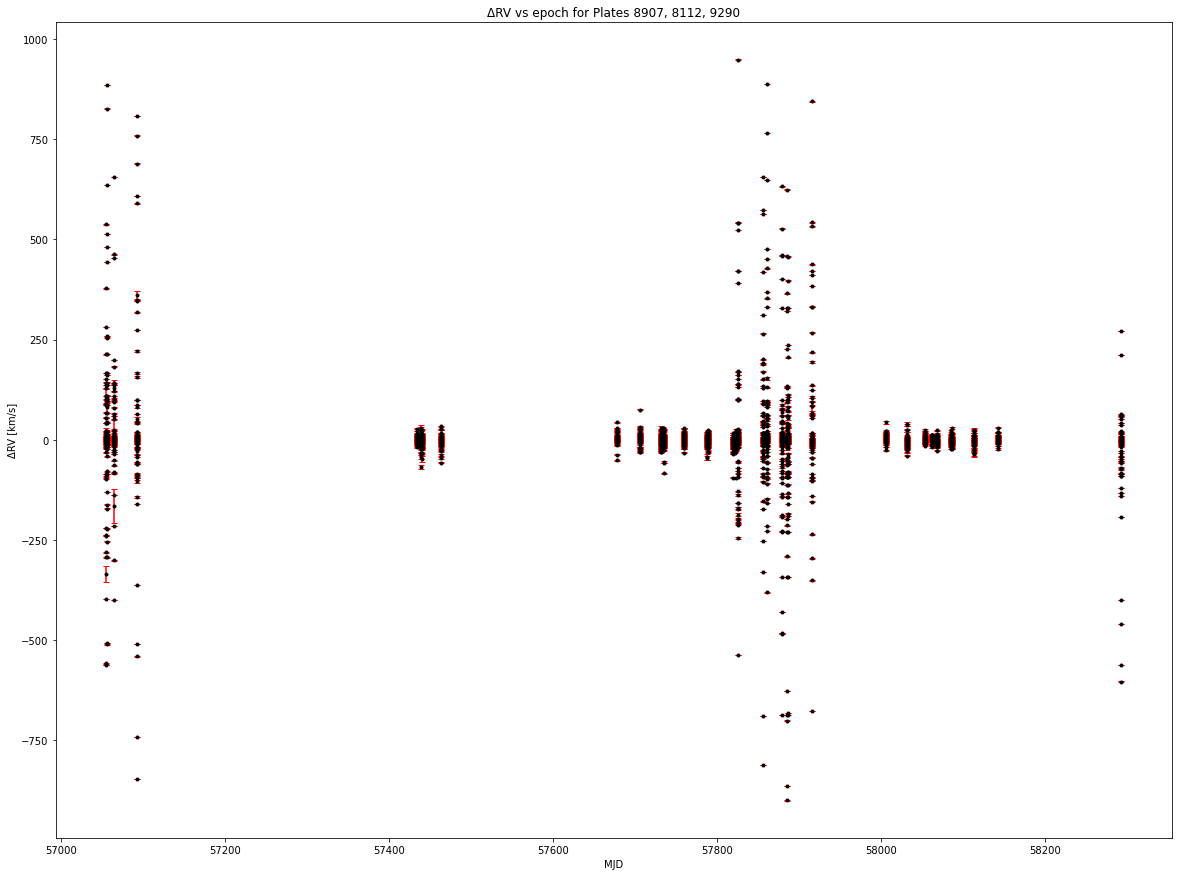

In [140]:
# Plot ΔRV versus epoch

x = mp_df['MJD']
y = mp_df['ΔRV']
yerr = mp_df['OBSVREL Error (km/s)']
plt.figure(figsize=(20, 15))
plt.errorbar(x, y, yerr, fmt='.', capsize=3, color='black', ecolor='r')
plt.title('ΔRV vs epoch for Plates 8907, 8112, 9290')
plt.xlabel('MJD')
plt.ylabel('ΔRV [km/s]')

## Step 2
- Condense all ΔRVs into a single point per MJD

### Step 2.5
- Calculate statistical/standard error: sigma_< RV > = sqrt(1/sum(weight))
- Plot statistical error bars

In [141]:
# Identify list of unique MJDs

unique_mjd = Counter(mp_df['MJD'])
unique_mjd_list = unique_mjd.keys()

In [142]:
unique_mjd_list

dict_keys([57706, 57732, 57734, 57735, 57760, 57788, 57789, 58006, 58032, 58054, 58063, 58068, 58085, 58087, 58114, 58143, 57434, 57439, 57440, 57463, 57678, 57819, 57822, 57823, 57055, 57056, 57064, 57092, 57826, 57856, 57861, 57879, 57886, 57887, 57916, 58293])

In [143]:
# Obtain weighted average ΔRV for each MJD

combined_weightedRVs = []
combined_staterror = []

for mjd in unique_mjd_list:
    mjd_df = mp_df[mp_df['MJD'] == mjd]
    mjd_RVs = list(mjd_df['ΔRV'])
    mjd_sigma = list(mjd_df['OBSVREL Error (km/s)'])
    weight = [1 / (mjd_sigma[s]**2) for s in range(len(mjd_sigma))]
    sigmaRV = 1000*np.sqrt(1/sum(weight))
    # print('Sum of ΔRV for MJD', mjd, ':', sum(mjd_RVs))
    # print('Sum of weights:', sum(weight))
    combined_weightedavg = 1000*sum([mjd_RVs[r] * weight[r] for r in range(len(mjd_RVs))]) / sum(weight) #[r] for r in range(len(mjd_sigma)))
    # combined_weightedavg = sum([mjd_RVs[r] * mjd_sigma[r] for r in range(len(mjd_RVs))]) / sum(mjd_sigma) #[r] for r in range(len(mjd_sigma)))
    combined_weightedRVs.append(combined_weightedavg)
    combined_staterror.append(sigmaRV)

In [20]:
#combined_weightedRVs # Expect order of 1-10 m/s; actually ~10-100 m/s, why??

In [21]:
#combined_staterror

In [144]:
# Create dataframe for MJD and combined weighted ΔRV values

weightedavg_data = [unique_mjd_list, combined_weightedRVs, combined_staterror]
weightedavg_df = pd.DataFrame(weightedavg_data).transpose()
weightedavg_df.columns = ['MJD', 'Combined ΔRV (m/s)', 'Combined σRV (m/s)']

In [23]:
#weightedavg_df

In [24]:
# Plot combined weighted ΔRV values vs MJD, with statistical error

#weightedavg_df.plot(x='MJD', y='Combined ΔRV (m/s)', yerr='Combined σRV (m/s)', kind='scatter', s=1, figsize=(10,10)) # Statistical error very hard to see

## Step 3
- Fit line to free parameters (i.e. x & y values), check gradient for anything interesting?

In [145]:
x = weightedavg_df['MJD']
y = weightedavg_df['Combined ΔRV (m/s)']
yerr = weightedavg_df['Combined σRV (m/s)']

In [146]:
a, b = np.polyfit(x, y, 1)

Text(0, 0.5, 'summed + weighted ΔRV [km/s]')

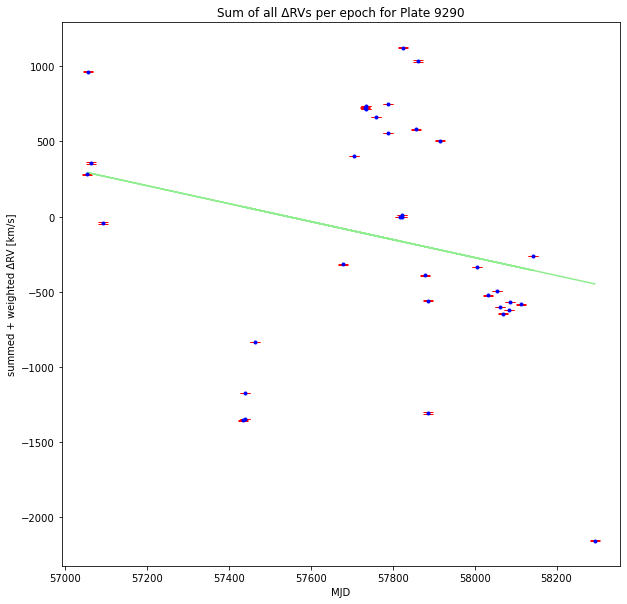

In [147]:
# Scatterplot of combined total ΔRVs per epoch for Plate 9290, with linear fit
plt.figure(figsize=(10, 10))
plt.errorbar(x, y, yerr, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
plt.title('Sum of all ΔRVs per epoch for Plate 9290')
plt.xlabel('MJD')
plt.ylabel('summed + weighted ΔRV [km/s]')

In [148]:
# Gradient - not sure how to interpret?

print('Gradient of slope:', a, '[m/MJD]')

Gradient of slope: -0.5977973884983322 [m/MJD]


## Step 4
- Check distribution of ~200 data points used to create combined ΔRV
    - Don't expect Gaussian, but should be relatively well-behaved (big tail suggests outlier that should be removed)
- Check distribution of all ΔRV per MJD

### Results
- All subhistograms centred around 0 ΔRV
- Some have certain big outliers
- What is the cutoff?
- Should I cut off overall, or for each subhistogram?

In [29]:
# Counter(df_cutoff['ΔRV'])

In [30]:
ΔRVdist = df['ΔRV']

(-10.0, 10.0)

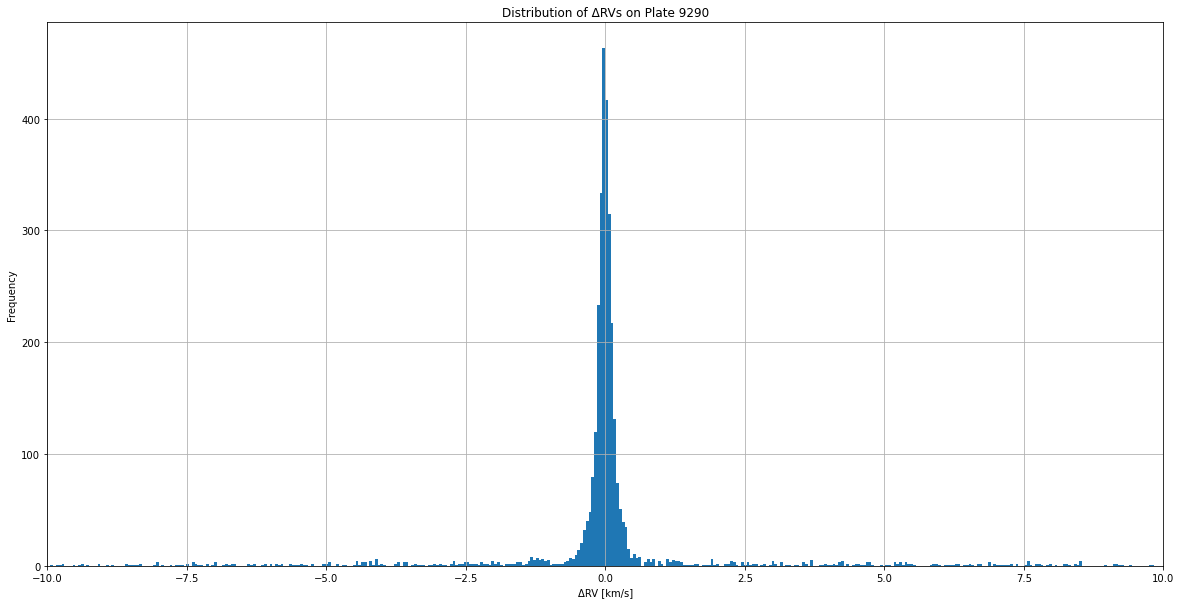

In [31]:
plt.figure(figsize=(20, 10))
ΔRVdist.plot.hist(grid=True, bins=2000, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290')
plt.xlabel('ΔRV [km/s]')
plt.xlim(-10, 10)

In [32]:
plt.figure(figsize=(20, 10))
df_cutoff['ΔRV'].plot.hist(grid=True, bins=2000, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290')
plt.xlabel('ΔRV [km/s]')
plt.xlim(-1, 1)

NameError: name 'df_cutoff' is not defined

<Figure size 1440x720 with 0 Axes>

### Distributions of ΔRV per MJD

In [ ]:
ΔRV_57706 = df[df['MJD'] == 57706]['ΔRV']*1000

In [ ]:
'''df_57706 = df[df['MJD'] == 57706]
ΔRV_57706 = df[df['MJD'] == 57706]['ΔRV']*1000
plt.figure(figsize=(20, 10))
ΔRV_57706.plot.hist(grid=True, bins=500, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290, MJD 57706')
plt.xlabel('ΔRV [m/s]')'''

In [ ]:
'''df_57732 = df[df['MJD'] == 57732]
plt.figure(figsize=(20, 10))
df_57732['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290, MJD 57732')
plt.xlabel('ΔRV [km/s]')'''

In [ ]:
'''df_57734 = df[df['MJD'] == 57734]
plt.figure(figsize=(20, 10))
df_57734['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290, MJD 57734')
plt.xlabel('ΔRV [km/s]')'''

In [ ]:
'''df_57735 = df[df['MJD'] == 57735]
plt.figure(figsize=(20, 10))
df_57735['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290, MJD 57735')
plt.xlabel('ΔRV [km/s]')'''

In [33]:
'''df_57760 = df[df['MJD'] == 57760]
plt.figure(figsize=(20, 10))
df_57760['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290, MJD 57760')
plt.xlabel('ΔRV [km/s]')'''

"df_57760 = df[df['MJD'] == 57760]\nplt.figure(figsize=(20, 10))\ndf_57760['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)\nplt.title('Distribution of ΔRVs on Plate 9290, MJD 57760')\nplt.xlabel('ΔRV [km/s]')"

In [34]:
'''df_57788 = df[df['MJD'] == 57788]
plt.figure(figsize=(20, 10))
df_57788['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290, MJD 57788')
plt.xlabel('ΔRV [km/s]')'''

"df_57788 = df[df['MJD'] == 57788]\nplt.figure(figsize=(20, 10))\ndf_57788['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)\nplt.title('Distribution of ΔRVs on Plate 9290, MJD 57788')\nplt.xlabel('ΔRV [km/s]')"

In [35]:
'''df_57789 = df[df['MJD'] == 57789]
plt.figure(figsize=(20, 10))
df_57789['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290, MJD 57789')
plt.xlabel('ΔRV [km/s]')'''

"df_57789 = df[df['MJD'] == 57789]\nplt.figure(figsize=(20, 10))\ndf_57789['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)\nplt.title('Distribution of ΔRVs on Plate 9290, MJD 57789')\nplt.xlabel('ΔRV [km/s]')"

In [36]:
'''df_58006 = df[df['MJD'] == 58006]
plt.figure(figsize=(20, 10))
df_58006['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290, MJD 58006')
plt.xlabel('ΔRV [km/s]')'''

"df_58006 = df[df['MJD'] == 58006]\nplt.figure(figsize=(20, 10))\ndf_58006['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)\nplt.title('Distribution of ΔRVs on Plate 9290, MJD 58006')\nplt.xlabel('ΔRV [km/s]')"

In [37]:
'''df_58032 = df[df['MJD'] == 58032]
plt.figure(figsize=(20, 10))
df_58032['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290, MJD 58032')
plt.xlabel('ΔRV [km/s]')'''

"df_58032 = df[df['MJD'] == 58032]\nplt.figure(figsize=(20, 10))\ndf_58032['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)\nplt.title('Distribution of ΔRVs on Plate 9290, MJD 58032')\nplt.xlabel('ΔRV [km/s]')"

In [38]:
'''df_58054 = df[df['MJD'] == 58054]
plt.figure(figsize=(20, 10))
df_58054['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290, MJD 58054')
plt.xlabel('ΔRV [km/s]')'''

"df_58054 = df[df['MJD'] == 58054]\nplt.figure(figsize=(20, 10))\ndf_58054['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)\nplt.title('Distribution of ΔRVs on Plate 9290, MJD 58054')\nplt.xlabel('ΔRV [km/s]')"

In [39]:
'''df_58063 = df[df['MJD'] == 58063]
plt.figure(figsize=(20, 10))
df_58063['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290, MJD 58063')
plt.xlabel('ΔRV [km/s]')'''

"df_58063 = df[df['MJD'] == 58063]\nplt.figure(figsize=(20, 10))\ndf_58063['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)\nplt.title('Distribution of ΔRVs on Plate 9290, MJD 58063')\nplt.xlabel('ΔRV [km/s]')"

In [40]:
'''df_58068 = df[df['MJD'] == 58068]
plt.figure(figsize=(20, 10))
df_58068['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290, MJD 58068')
plt.xlabel('ΔRV [km/s]')'''

"df_58068 = df[df['MJD'] == 58068]\nplt.figure(figsize=(20, 10))\ndf_58068['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)\nplt.title('Distribution of ΔRVs on Plate 9290, MJD 58068')\nplt.xlabel('ΔRV [km/s]')"

In [41]:
'''df_58085 = df[df['MJD'] == 58085]
plt.figure(figsize=(20, 10))
df_58085['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290, MJD 58085')
plt.xlabel('ΔRV [km/s]')'''

"df_58085 = df[df['MJD'] == 58085]\nplt.figure(figsize=(20, 10))\ndf_58085['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)\nplt.title('Distribution of ΔRVs on Plate 9290, MJD 58085')\nplt.xlabel('ΔRV [km/s]')"

In [42]:
'''df_58087 = df[df['MJD'] == 58087]
plt.figure(figsize=(20, 10))
df_58087['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290, MJD 58087')
plt.xlabel('ΔRV [km/s]')'''

"df_58087 = df[df['MJD'] == 58087]\nplt.figure(figsize=(20, 10))\ndf_58087['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)\nplt.title('Distribution of ΔRVs on Plate 9290, MJD 58087')\nplt.xlabel('ΔRV [km/s]')"

In [43]:
'''df_58114 = df[df['MJD'] == 58114]
plt.figure(figsize=(20, 10))
df_58114['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290, MJD 58114')
plt.xlabel('ΔRV [km/s]')'''

"df_58114 = df[df['MJD'] == 58114]\nplt.figure(figsize=(20, 10))\ndf_58114['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)\nplt.title('Distribution of ΔRVs on Plate 9290, MJD 58114')\nplt.xlabel('ΔRV [km/s]')"

In [44]:
'''df_58143 = df[df['MJD'] == 58143]
plt.figure(figsize=(20, 10))
df_58143['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)
plt.title('Distribution of ΔRVs on Plate 9290, MJD 58143')
plt.xlabel('ΔRV [km/s]')'''

"df_58143 = df[df['MJD'] == 58143]\nplt.figure(figsize=(20, 10))\ndf_58143['ΔRV'].plot.hist(grid=True, bins=500, rwidth=1)\nplt.title('Distribution of ΔRVs on Plate 9290, MJD 58143')\nplt.xlabel('ΔRV [km/s]')"

Gaussian Mixture Model

In [45]:
# Data X is a 2-D array? 

/var/folders/hh/025gcjhx0zx_78ws1t9nf3f80000gn/T/ipykernel_25851/3167383925.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, S, 'bo-', color='black')


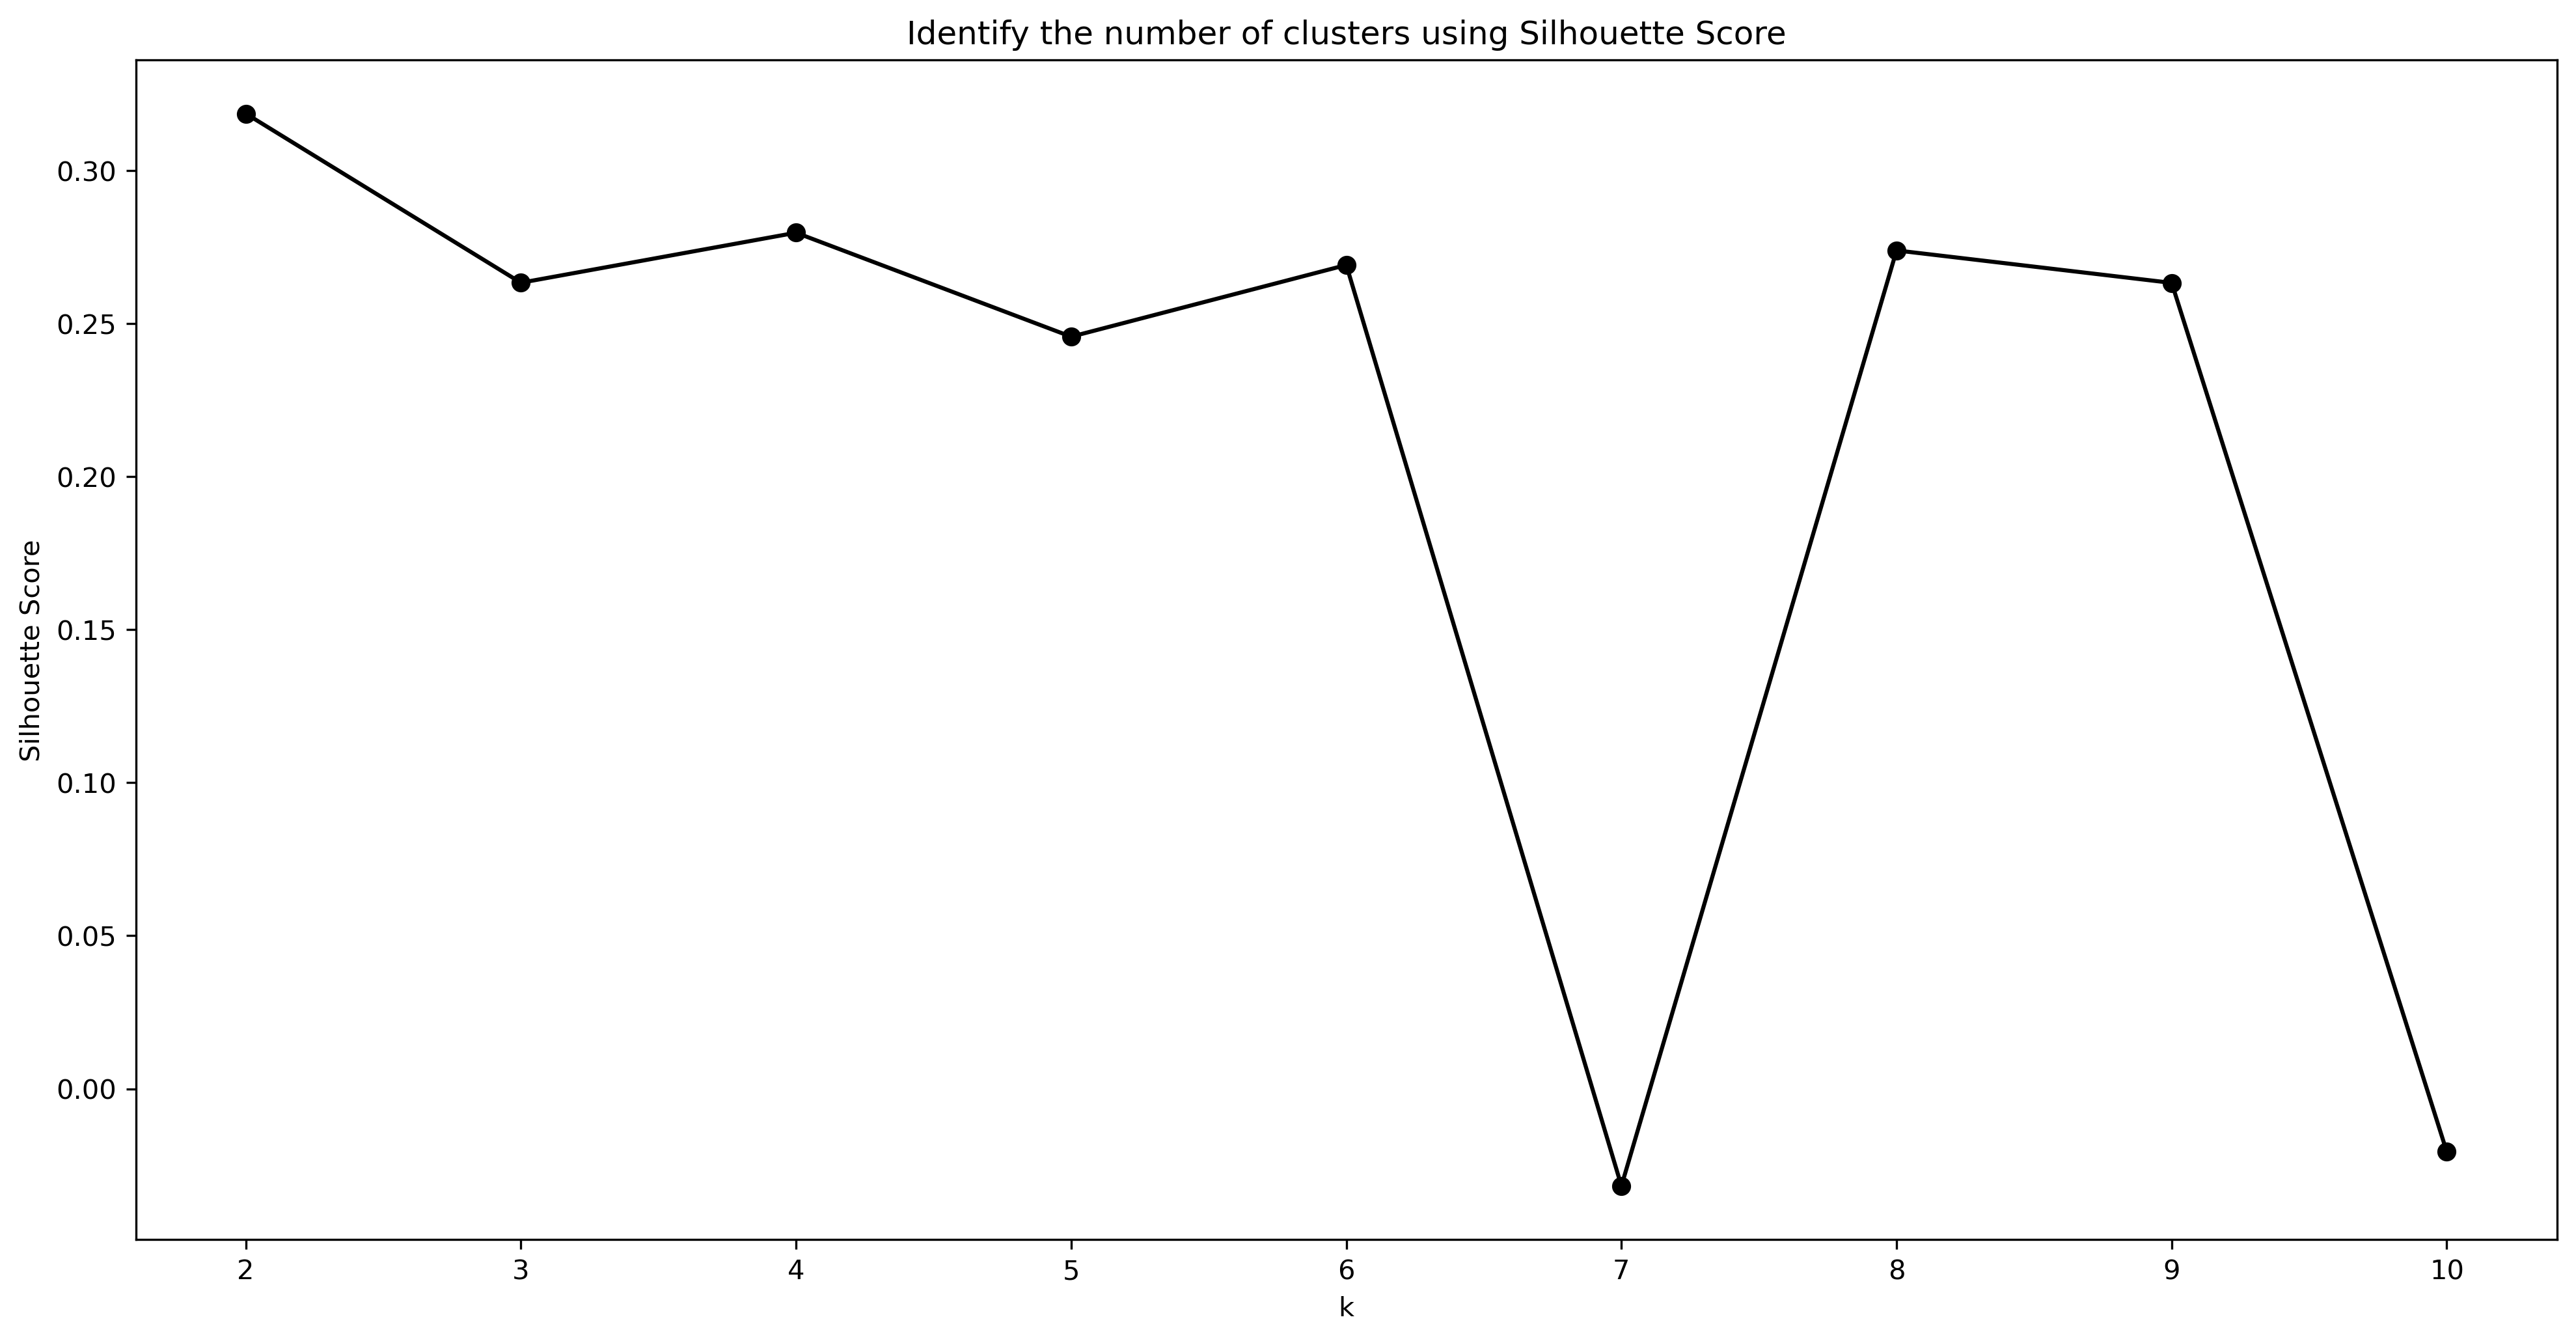

In [149]:
# Create empty list
S=[]

# Range of clusters to try (2 to 10)
K=range(2,11)

# Select data for clustering model
X = mp_df[['OBSVREL Error (km/s)', 'ΔRV']]

for k in K:
    # Set the model and its parameters
    model = GaussianMixture(n_components=k, n_init=20, init_params='kmeans')
    # Fit the model 
    labels = model.fit_predict(X)
    # Calculate Silhoutte Score and append to a list
    S.append(metrics.silhouette_score(X, labels, metric='euclidean'))

# Plot the resulting Silhouette scores on a graph
plt.figure(figsize=(16,8), dpi=300)
plt.plot(K, S, 'bo-', color='black')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Identify the number of clusters using Silhouette Score')
plt.show()

In [150]:
# Select data for clustering model
X = mp_df[['OBSVREL Error (km/s)', 'ΔRV']]

# Set the model and its parameters - 2 clusters
model = GaussianMixture(n_components=2, # this is the number of clusters
                         covariance_type='full', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’
                         max_iter=1000, # the number of EM iterations to perform. default=100
                         n_init=10, # the number of initializations to perform. default = 1
                         init_params='random', # the method used to initialize the weights, the means and the precisions. {'random' or default='k-means'}
                         verbose=0, # default 0, {0,1,2}
                         random_state=1 # for reproducibility
                        )

# Fit the model and predict labels
clust2 = model.fit(X)
labels2 = model.predict(X)

# Generate 10,000 new samples based on the model
smpl=model.sample(n_samples=10000)

# Model summary
print('*************** 2 Cluster Model ***************')
print('Weights: ', clust2.weights_)
print('Means: ', clust2.means_)
print('Covariances: ', clust2.covariances_)
print('Precisions: ', clust2.precisions_)
#print('Precisions Cholesky: ', clust2.precisions_cholesky_)
print('Converged: ', clust2.converged_)
print(' No. of Iterations: ', clust2.n_iter_)
print('Lower Bound: ', clust2.lower_bound_)

*************** 2 Cluster Model ***************
Weights:  [0.61916013 0.38083987]
Means:  [[ 0.01823213 -0.00630366]
 [ 0.70409687  2.27195728]]
Covariances:  [[[ 2.66038600e-04 -2.53405844e-06]
  [-2.53405844e-06  3.37688023e-02]]

 [[ 1.84306285e+00 -1.89400745e+00]
  [-1.89400745e+00  8.85568547e+03]]]
Precisions:  [[[3.75885573e+03 2.82069822e-01]
  [2.82069822e-01 2.96131531e+01]]

 [[5.42694371e-01 1.16068619e-04]
  [1.16068619e-04 1.12946631e-04]]]
Converged:  True
 No. of Iterations:  42
Lower Bound:  -1.7408610174440444


In [151]:
# Attach cluster labels to the main dataframe
mp_df['Cluster']=labels2

In [152]:
mp_df

,Target ID,MJD,OBSVHELIO (km/s),OBSVREL Error (km/s),<RV>,ΔRV,Cluster
0,apo25m.5226.150-08-RV.2M03252400+4614203,57706,-86.565704,0.010245,-86.476541,-0.089163,0
1,apo25m.5226.150-08-RV.2M03252400+4614203,57732,-86.383430,0.008206,-86.476541,0.093111,0
2,apo25m.5226.150-08-RV.2M03252400+4614203,57734,-86.386870,0.009015,-86.476541,0.089671,0
3,apo25m.5226.150-08-RV.2M03252400+4614203,57735,-86.532840,0.010742,-86.476541,-0.056299,0
4,apo25m.5226.150-08-RV.2M03252400+4614203,57760,-86.366640,0.012035,-86.476541,0.109901,0
...,...,...,...,...,...,...,...
10664,apo25m.5118.URMINOR.2M15260674+6734563,57879,0.493465,0.061337,0.435488,0.057977,0
10665,apo25m.5118.URMINOR.2M15260674+6734563,57886,0.285309,0.083303,0.435488,-0.150180,0
10666,apo25m.5118.URMINOR.2M15260674+6734563,57887,0.420483,0.067660,0.435488,-0.015006,0
10667,apo25m.5118.URMINOR.2M15260674+6734563,57916,0.399855,0.066620,0.435488,-0.035634,0


<AxesSubplot:xlabel='Cluster', ylabel='ΔRV'>

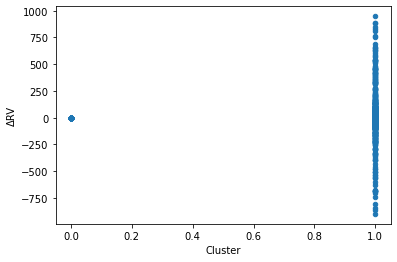

In [153]:
mp_df.plot(x='Cluster', y='ΔRV', kind='scatter')

<AxesSubplot:xlabel='MJD', ylabel='Cluster'>

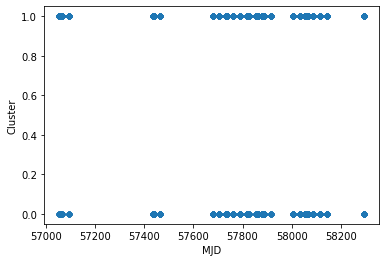

In [154]:
mp_df.plot(x='MJD', y='Cluster', kind='scatter')

In [155]:
df0 = mp_df[mp_df['Cluster'] == 0]
df1 = mp_df[mp_df['Cluster'] == 1]

In [156]:
df0['ΔRV'].describe()

count    6604.000000
mean       -0.005951
std         0.183792
min        -0.867057
25%        -0.096697
50%        -0.008965
75%         0.084810
max         0.857364
Name: ΔRV, dtype: float64

In [157]:
df1['ΔRV'].describe()

count    4065.000000
mean        2.270364
std        94.095190
min      -900.223293
25%        -2.383085
50%         0.003261
75%         2.310525
max       948.777856
Name: ΔRV, dtype: float64

In [158]:
df0['OBSVREL Error (km/s)'].describe()

count    6604.000000
mean        0.018160
std         0.016089
min         0.000637
25%         0.008067
50%         0.012554
75%         0.021946
max         0.095137
Name: OBSVREL Error (km/s), dtype: float64

In [159]:
df1['OBSVREL Error (km/s)'].describe()

count    4065.000000
mean        0.703907
std         1.357479
min         0.000470
25%         0.151363
50%         0.296589
75%         0.763401
max        42.168373
Name: OBSVREL Error (km/s), dtype: float64

In [160]:
y0 = df0['ΔRV']
y1 = df1['ΔRV']
x0 = df0['MJD']
x1 = df1['MJD']

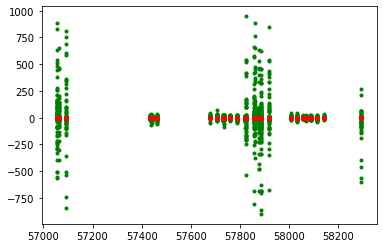

In [161]:
plt.plot(x1, y1, '.', color='g')
plt.plot(x0, y0, '.', color='r')

(-0.68658, 0.637125)

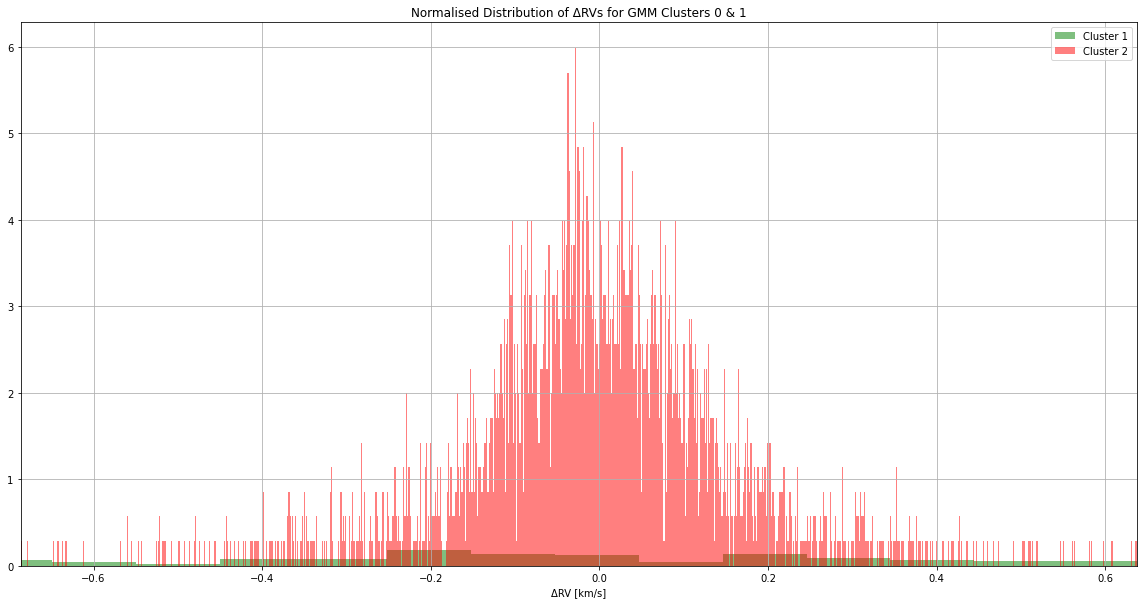

In [59]:
plt.figure(figsize=(20,10))
plt.hist(x=df1['ΔRV'], bins=1000, alpha=0.5, color='g', label='Cluster 1', density=True)
plt.hist(x=df0['ΔRV'], bins=1000, alpha=0.5, color='r', label='Cluster 2', density=True)
#df1['ΔRV'].plot.hist(grid=True, bins=1000, rwidth=1, color='g', alpha=0.5, label='Cluster 1')
#df0['ΔRV'].plot.hist(grid=True, bins=1000, rwidth=1, color='r', alpha=0.5, label='Cluster 0')
plt.title('Normalised Distribution of ΔRVs for GMM Clusters 0 & 1')
plt.legend()
plt.xlabel('ΔRV [km/s]')
plt.grid()
plt.xlim(-0.686580, 0.637125)

mu: -0.005950644235066459 std: 0.18377772565871067


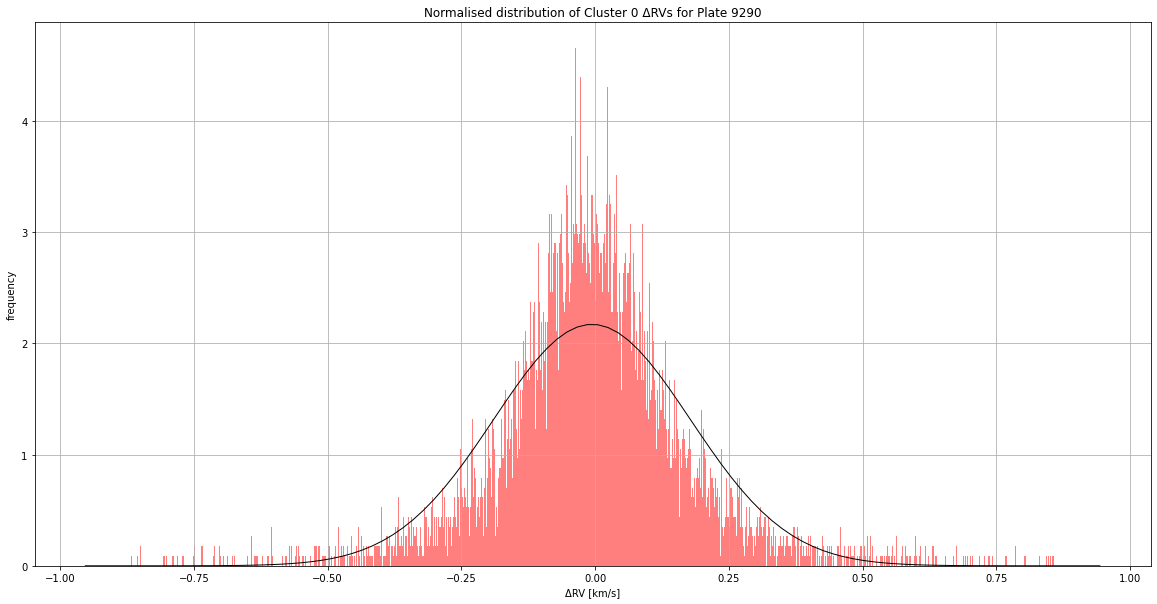

In [163]:
mu0, std0 = norm.fit(df0['ΔRV'])

plt.figure(figsize=(20,10))
plt.hist(x=df0['ΔRV'], bins=1000, alpha=0.5, color='r', label='Cluster 2', density=True)
xmin0, xmax0 = plt.xlim()
x0 = np.linspace(xmin0, xmax0, 100)
p0 = norm.pdf(x0, mu0, std0)  
plt.plot(x0, p0, 'k', linewidth=1)
plt.grid()
plt.title('Normalised distribution of Cluster 0 ΔRVs for Plate 9290')
plt.xlabel('ΔRV [km/s]')
plt.ylabel('frequency')
print('mu:', mu0, 'std:', std0)

In [61]:
(df0['ΔRV'][0] - mu0)**2

0.007055359016120949

In [62]:
range(len(df0['ΔRV']))

range(0, 2651)

In [63]:
pdf = []

for drv0 in df0['ΔRV']:
    gx0 = (1/(std0 * np.sqrt(2*np.pi))) * np.exp(-0.5 * (((drv0-mu0)/std0))**2)
    pdf.append(gx0)

In [64]:
sum(pdf)

4916.486292037104

In [164]:
np.sort(list(np.random.normal(0, std0, 1000000)))[50000]

-0.30155426259301604

In [66]:
sig0 = sum((list(df0['ΔRV'])[dr] - mu0)**2 for dr in range(len(df0['ΔRV']))) / len(df0['ΔRV'])

pdf0 = []
#cluster0_recalc = []

for drv0 in df0['ΔRV']:
    gx0 = (1/(sig0 * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((drv0-mu0)**2)/(sig0**2))
    pdf0.append(gx0)
    #if gx0 > 0.95:
    #    cluster0_recalc.append(0)
    #else:
    #    cluster0_recalc.append(1)

In [67]:
pdf0

[0.09680107548583022,
 9.078912061135412e-46,
 2.684063522871219,
 2.392349603972126,
 0.0602070290024875,
 5.319752217886645,
 0.11758950507758147,
 0.008623770929653636,
 4.143028550719827,
 9.898868822283843,
 0.13228458249553232,
 0.0011572343872429348,
 2.3235943138587634,
 0.024168971908850263,
 0.015023774418428679,
 0.053225901021947214,
 11.294208085502778,
 0.5412348997940434,
 5.517851029782267e-05,
 1.6758451666536705e-12,
 12.081828294962476,
 0.0033733446593001595,
 0.0035601475400379567,
 8.665697168956845,
 0.01177228178846418,
 8.26006537598546,
 14.326800566959106,
 1.0226289116062797,
 0.025016639545450636,
 4.034486153841246e-06,
 14.601178157449343,
 8.248914809690291,
 14.515872180849804,
 1.0419811093307807,
 4.631450216553965,
 7.193469407945997,
 1.6400837478626502,
 1.9863234287824243e-07,
 0.0005763504544672565,
 14.895310064558222,
 8.40696604557223,
 1.9998788681164277e-08,
 14.797444929980225,
 7.148809850845065e-37,
 7.872312868288956e-19,
 2.374127881551

mu: -0.15018285930963515 std: 9.364465480901352


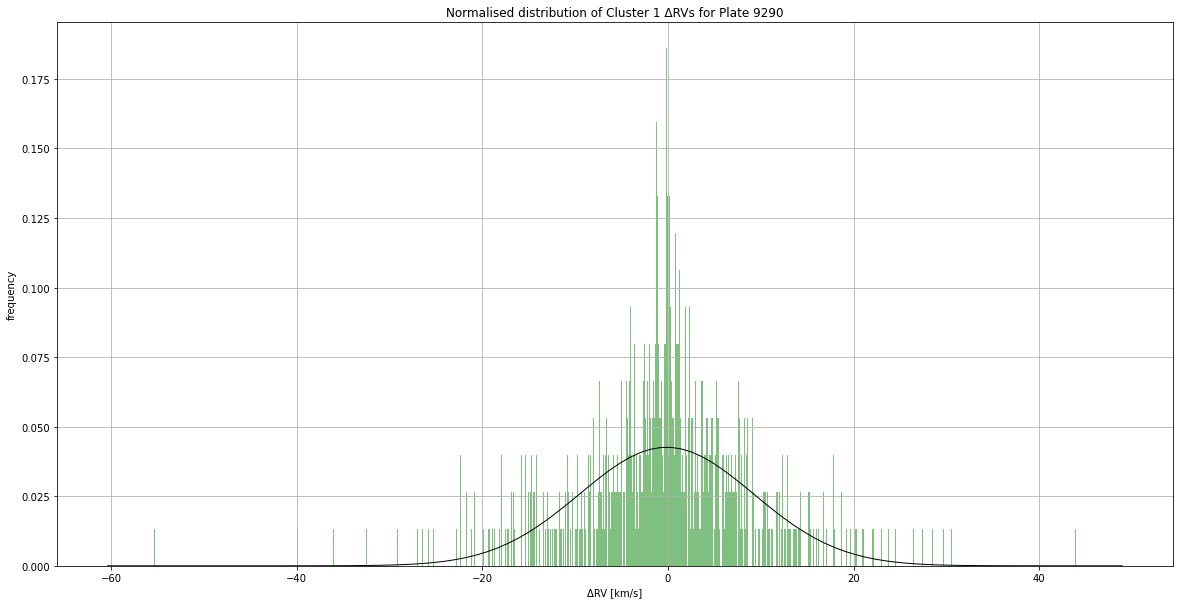

In [69]:
mu1, std1 = norm.fit(df1['ΔRV'])

plt.figure(figsize=(20,10))
plt.hist(x=df1['ΔRV'], bins=1000, alpha=0.5, color='g', label='Cluster 2', density=True)
x1min, x1max = plt.xlim()
x1 = np.linspace(x1min, x1max, 100)
p1 = norm.pdf(x1, mu1, std1)  
plt.plot(x1, p1, 'k', linewidth=1)
plt.grid()
plt.title('Normalised distribution of Cluster 1 ΔRVs for Plate 9290')
plt.xlabel('ΔRV [km/s]')
plt.ylabel('frequency')
print('mu:', mu1, 'std:', std1)

mu: -0.037378303952802935 std: 4.416219868171523


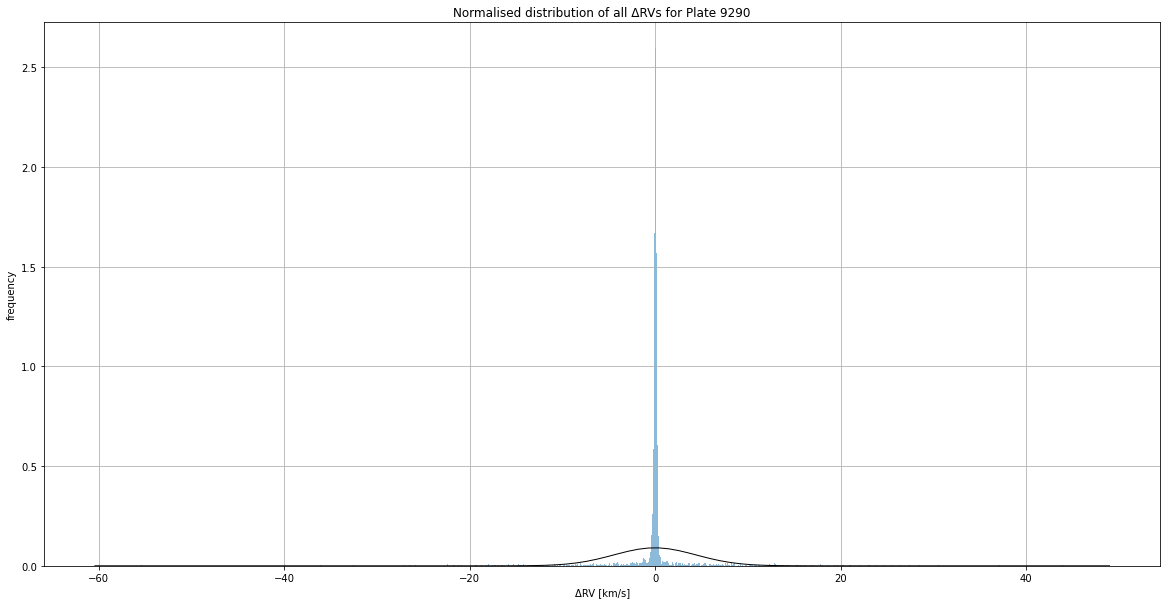

In [70]:
mu, std = norm.fit(df['ΔRV'])

plt.figure(figsize=(20,10))
plt.hist(x=df['ΔRV'], bins=1000, alpha=0.5, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)  
plt.plot(x, p, 'k', linewidth=1)
plt.grid()
plt.title('Normalised distribution of all ΔRVs for Plate 9290')
plt.xlabel('ΔRV [km/s]')
plt.ylabel('frequency')
print('mu:', mu, 'std:', std)

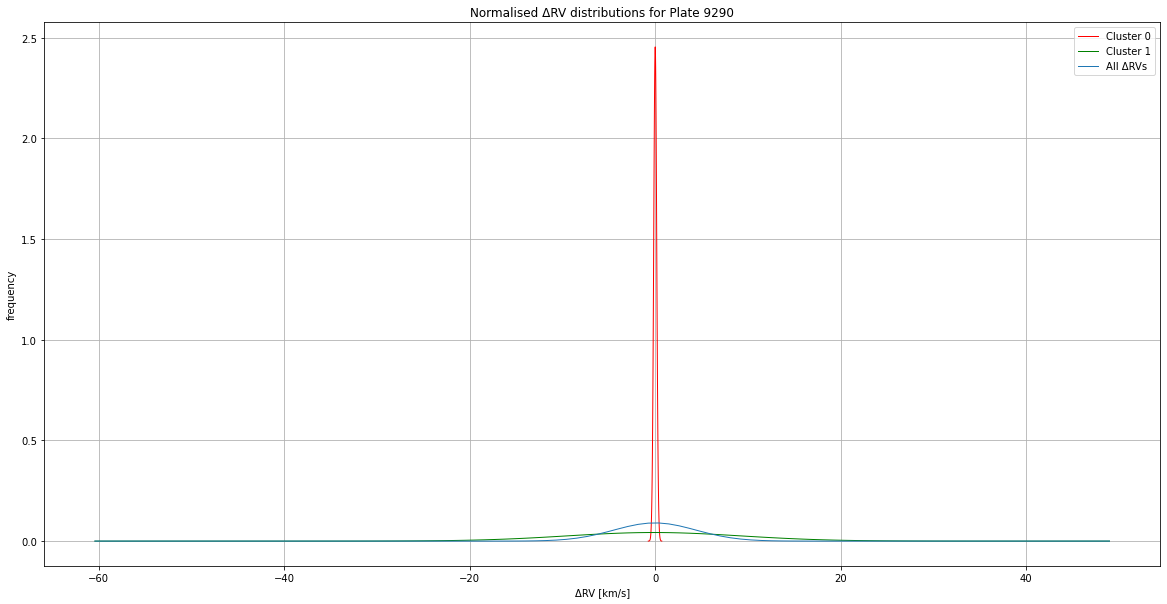

In [71]:
plt.figure(figsize=(20,10))
plt.plot(x0, p0, linewidth=1, color='r', label='Cluster 0')
plt.plot(x1, p1, linewidth=1, color='g', label='Cluster 1')
plt.plot(x, p, linewidth=1, label='All ΔRVs')
plt.grid()
plt.title('Normalised ΔRV distributions for Plate 9290')
plt.xlabel('ΔRV [km/s]')
plt.ylabel('frequency')
plt.legend()

In [72]:
x1

array([-60.39783266, -59.29321521, -58.18859777, -57.08398033,
       -55.97936288, -54.87474544, -53.77012799, -52.66551055,
       -51.5608931 , -50.45627566, -49.35165821, -48.24704077,
       -47.14242332, -46.03780588, -44.93318844, -43.82857099,
       -42.72395355, -41.6193361 , -40.51471866, -39.41010121,
       -38.30548377, -37.20086632, -36.09624888, -34.99163144,
       -33.88701399, -32.78239655, -31.6777791 , -30.57316166,
       -29.46854421, -28.36392677, -27.25930932, -26.15469188,
       -25.05007444, -23.94545699, -22.84083955, -21.7362221 ,
       -20.63160466, -19.52698721, -18.42236977, -17.31775232,
       -16.21313488, -15.10851744, -14.00389999, -12.89928255,
       -11.7946651 , -10.69004766,  -9.58543021,  -8.48081277,
        -7.37619532,  -6.27157788,  -5.16696044,  -4.06234299,
        -2.95772555,  -1.8531081 ,  -0.74849066,   0.35612679,
         1.46074423,   2.56536168,   3.66997912,   4.77459656,
         5.87921401,   6.98383145,   8.0884489 ,   9.19

In [73]:
x

array([-60.39783266, -59.29321521, -58.18859777, -57.08398033,
       -55.97936288, -54.87474544, -53.77012799, -52.66551055,
       -51.5608931 , -50.45627566, -49.35165821, -48.24704077,
       -47.14242332, -46.03780588, -44.93318844, -43.82857099,
       -42.72395355, -41.6193361 , -40.51471866, -39.41010121,
       -38.30548377, -37.20086632, -36.09624888, -34.99163144,
       -33.88701399, -32.78239655, -31.6777791 , -30.57316166,
       -29.46854421, -28.36392677, -27.25930932, -26.15469188,
       -25.05007444, -23.94545699, -22.84083955, -21.7362221 ,
       -20.63160466, -19.52698721, -18.42236977, -17.31775232,
       -16.21313488, -15.10851744, -14.00389999, -12.89928255,
       -11.7946651 , -10.69004766,  -9.58543021,  -8.48081277,
        -7.37619532,  -6.27157788,  -5.16696044,  -4.06234299,
        -2.95772555,  -1.8531081 ,  -0.74849066,   0.35612679,
         1.46074423,   2.56536168,   3.66997912,   4.77459656,
         5.87921401,   6.98383145,   8.0884489 ,   9.19

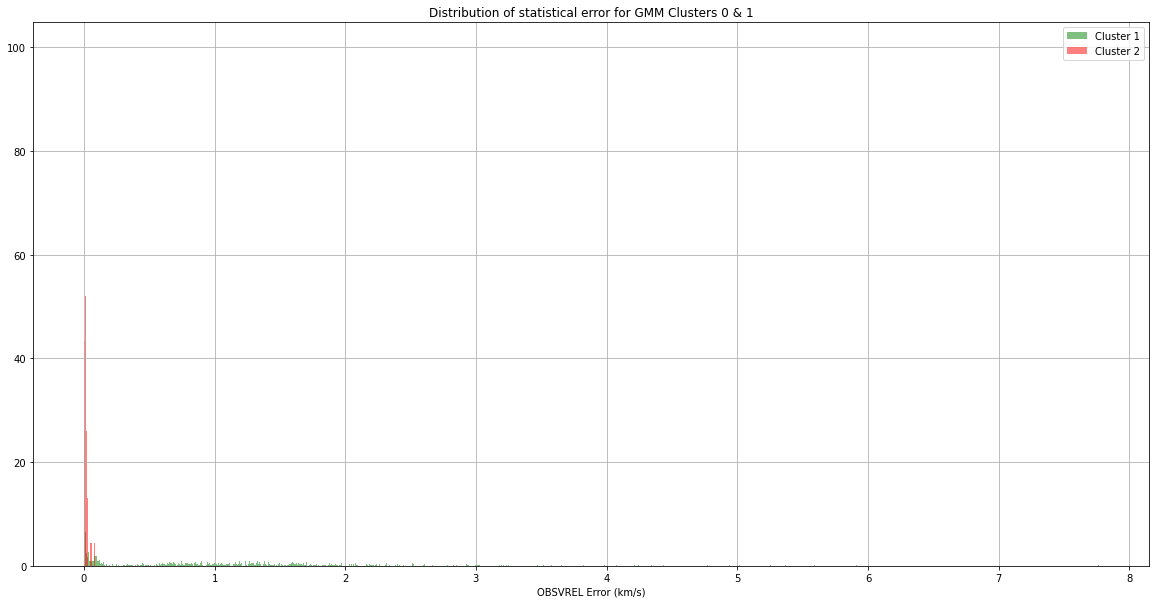

In [74]:
plt.figure(figsize=(20,10))
plt.hist(x=df1['OBSVREL Error (km/s)'], bins=1000, alpha=0.5, color='g', label='Cluster 1', density=True)
plt.hist(x=df0['OBSVREL Error (km/s)'], bins=1000, alpha=0.5, color='r', label='Cluster 2', density=True)
#df1['OBSVREL Error (km/s)'].plot.hist(grid=True, bins=1000, rwidth=1, color='g', alpha=0.5, label='Cluster 1')
#df0['OBSVREL Error (km/s)'].plot.hist(grid=True, bins=1000, rwidth=1, color='r', alpha=0.5, label='Cluster 0')
plt.title('Distribution of statistical error for GMM Clusters 0 & 1')
plt.legend()
plt.xlabel('OBSVREL Error (km/s)')
plt.grid()
#plt.xlim(0.001236, 0.088124)

Text(0.5, 0, 'ΔRV [km/s]')

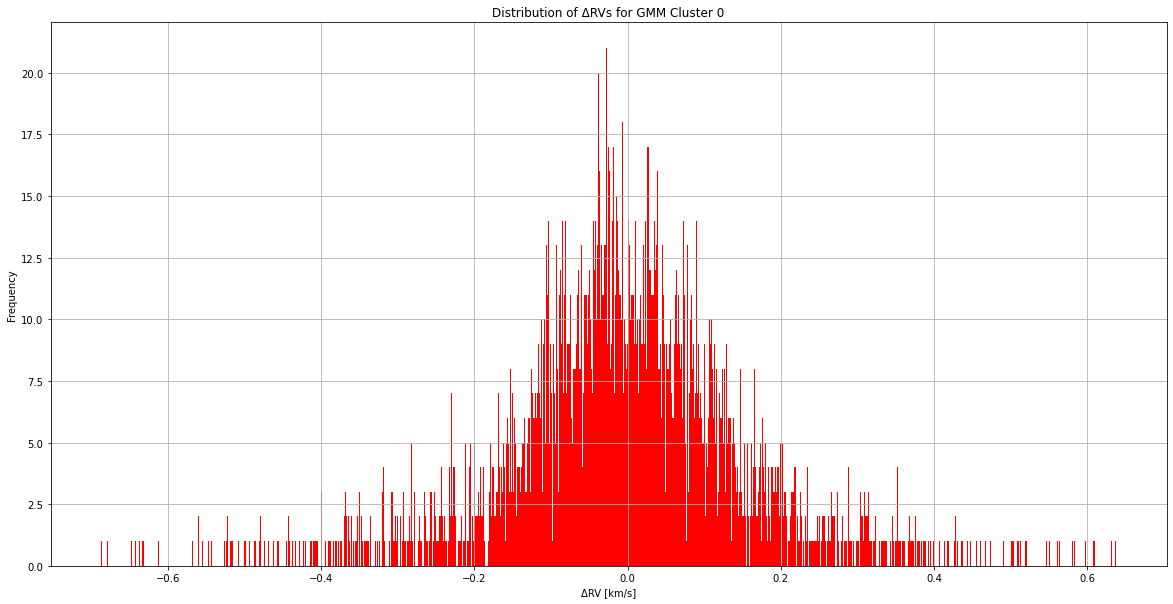

In [75]:
plt.figure(figsize=(20, 10))
df0['ΔRV'].plot.hist(grid=True, bins=1000, rwidth=1, color='r')
plt.title('Distribution of ΔRVs for GMM Cluster 0')
plt.xlabel('ΔRV [km/s]')

Text(0.5, 0, 'ΔRV [km/s]')

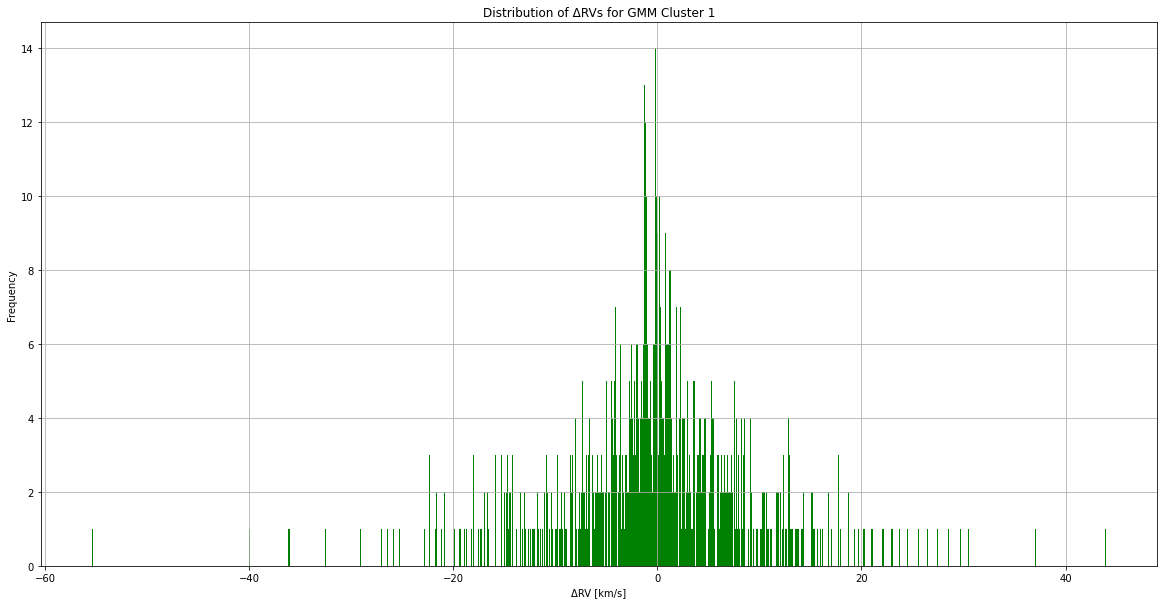

In [76]:
plt.figure(figsize=(20, 10))
df1['ΔRV'].plot.hist(grid=True, bins=1000, rwidth=1, color='g')
plt.title('Distribution of ΔRVs for GMM Cluster 1')
plt.xlabel('ΔRV [km/s]')
#plt.xlim(-0.686580, 0.637125)

In [168]:
# Consider limiting ΔRV range?

df_cutoff = mp_df.loc[(mp_df['ΔRV'] < 0.30155426259301604) & (mp_df['ΔRV'] > -0.30155426259301604)]
#df_cutoff = df.loc[(df['ΔRV'] < 1) & (df['ΔRV'] > -1)]
df_cutoff.sort_values('ΔRV')

,Target ID,MJD,OBSVHELIO (km/s),OBSVREL Error (km/s),<RV>,ΔRV,Cluster
2221,apo25m.5226.150-08-RV.2M03335510+4525265,58054,-60.069443,0.009608,-59.768067,-0.301376,0
5956,apo25m.5176.COROTA2-RV.2M06504009-0336271,57706,74.374596,0.025135,74.675694,-0.301098,0
8437,apo25m.5118.URMINOR.2M15070093+6701498,57826,-64.221730,0.433119,-63.920768,-0.300962,1
7734,apo25m.5176.COROTA2-RV.2M06545052-0520509,57434,91.174520,0.011486,91.475363,-0.300843,0
1543,apo25m.5226.150-08-RV.2M03314528+4629182,58087,-23.296644,0.042131,-22.996190,-0.300454,0
...,...,...,...,...,...,...,...
4615,apo25m.5176.COROTA2-RV.2M06482507-0426272,57760,29.654640,0.005156,29.355605,0.299035,0
5350,apo25m.5176.COROTA2-RV.2M06494300-0554289,57822,66.805570,0.013239,66.505273,0.300297,0
1791,apo25m.5226.150-08-RV.2M03323426+4539131,58032,-62.699356,0.068965,-63.000188,0.300832,0
905,apo25m.5226.150-08-RV.2M03294792+4706508,58032,-41.237260,0.087552,-41.538365,0.301105,0


In [169]:
df_cutoff['ΔRV'].describe()

count    6559.000000
mean       -0.005454
std         0.126773
min        -0.301376
25%        -0.089043
50%        -0.008208
75%         0.078347
max         0.301468
Name: ΔRV, dtype: float64

Text(0, 0.5, 'ΔRV [km/s]')

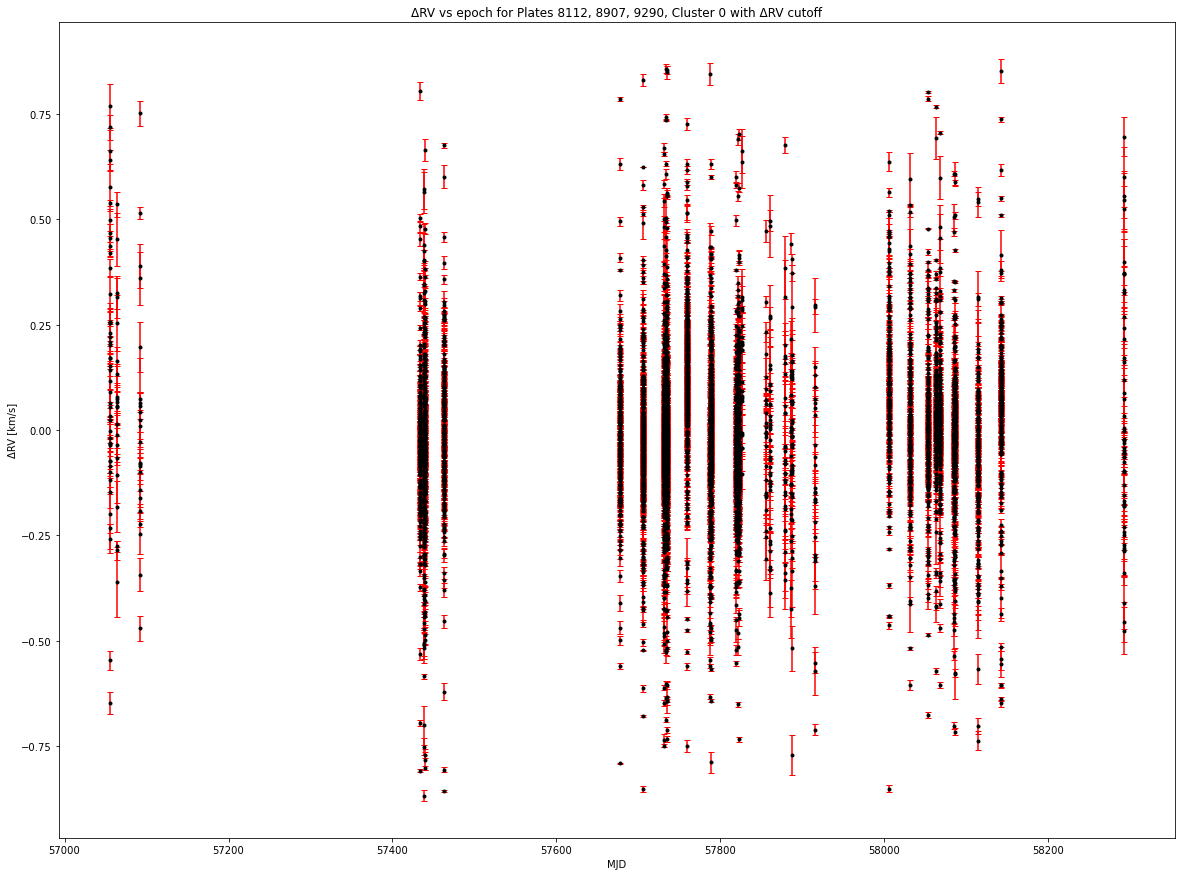

In [178]:
# Plot ΔRV versus epoch for cutoff dataframe

x = df0['MJD']
y = df0['ΔRV']
yerr = df0['OBSVREL Error (km/s)']
#x = df_cutoff['MJD']
#y = df_cutoff['ΔRV']
#yerr = df_cutoff['OBSVREL Error (km/s)']
plt.figure(figsize=(20, 15))
plt.errorbar(x, y, yerr, fmt='.', capsize=3, color='black', ecolor='r')
plt.title('ΔRV vs epoch for Plates 8112, 8907, 9290, Cluster 0 with ΔRV cutoff')
plt.xlabel('MJD')
plt.ylabel('ΔRV [km/s]')

#df_cutoff.plot(x = 'MJD', y = 'ΔRV', kind = 'scatter', figsize=(15,10))

In [171]:
unique_mjd_cf = Counter(df_cutoff['MJD'])
unique_mjd_cflist = unique_mjd_cf.keys()

In [172]:
# Obtain weighted average ΔRV for each MJD

combined_weightedRVs_cutoff = []
combined_staterror_cutoff = []
weights = []

for mjd in unique_mjd_cflist:
    mjd_df = df_cutoff[df_cutoff['MJD'] == mjd]
    mjd_RVs = list(mjd_df['ΔRV'])
    mjd_sigma = list(mjd_df['OBSVREL Error (km/s)'])
    weight = [1 / (mjd_sigma[s]**2) for s in range(len(mjd_sigma))]
    sigmaRV = 1000*np.sqrt(1/sum(weight))
    # print('Sum of ΔRV for MJD', mjd, ':', sum(mjd_RVs))
    # print('Sum of weights:', sum(weight))
    combined_weightedavg = 1000*sum([mjd_RVs[r] * weight[r] for r in range(len(mjd_RVs))]) / sum(weight) #[r] for r in range(len(mjd_sigma)))
    # combined_weightedavg = sum([mjd_RVs[r] * mjd_sigma[r] for r in range(len(mjd_RVs))]) / sum(mjd_sigma) #[r] for r in range(len(mjd_sigma)))
    combined_weightedRVs_cutoff.append(combined_weightedavg)
    combined_staterror_cutoff.append(sigmaRV)
    weights.append(weight)

In [173]:
df0 #[df0['MJD'] == 58143]

,Target ID,MJD,OBSVHELIO (km/s),OBSVREL Error (km/s),<RV>,ΔRV,Cluster
0,apo25m.5226.150-08-RV.2M03252400+4614203,57706,-86.565704,0.010245,-86.476541,-0.089163,0
1,apo25m.5226.150-08-RV.2M03252400+4614203,57732,-86.383430,0.008206,-86.476541,0.093111,0
2,apo25m.5226.150-08-RV.2M03252400+4614203,57734,-86.386870,0.009015,-86.476541,0.089671,0
3,apo25m.5226.150-08-RV.2M03252400+4614203,57735,-86.532840,0.010742,-86.476541,-0.056299,0
4,apo25m.5226.150-08-RV.2M03252400+4614203,57760,-86.366640,0.012035,-86.476541,0.109901,0
...,...,...,...,...,...,...,...
10664,apo25m.5118.URMINOR.2M15260674+6734563,57879,0.493465,0.061337,0.435488,0.057977,0
10665,apo25m.5118.URMINOR.2M15260674+6734563,57886,0.285309,0.083303,0.435488,-0.150180,0
10666,apo25m.5118.URMINOR.2M15260674+6734563,57887,0.420483,0.067660,0.435488,-0.015006,0
10667,apo25m.5118.URMINOR.2M15260674+6734563,57916,0.399855,0.066620,0.435488,-0.035634,0


In [174]:
# Create dataframe for MJD and combined weighted ΔRV values

weightedavg_data_cutoff = [unique_mjd_cflist, combined_weightedRVs_cutoff, combined_staterror_cutoff]
weightedavg_df_cutoff = pd.DataFrame(weightedavg_data_cutoff).transpose()
weightedavg_df_cutoff.columns = ['MJD', 'Combined ΔRV (m/s)', 'Combined σRV (m/s)']

In [175]:
weightedavg_df_cutoff

,MJD,Combined ΔRV (m/s),Combined σRV (m/s)
0,57706.0,-38.712200,0.370361
1,57732.0,-22.118102,0.387643
2,57734.0,44.334602,0.304781
3,57735.0,-12.731824,0.393091
4,57760.0,92.078307,0.402091
5,57788.0,-93.128264,0.922952
6,57789.0,-15.463829,0.335085
7,58006.0,36.140368,0.484830
8,58032.0,-9.367240,0.661798
9,58054.0,-40.832366,0.457570


In [85]:
df0[df0['MJD'] == 58143]

,Target ID,MJD,OBSVHELIO (km/s),OBSVREL Error (km/s),<RV>,ΔRV,Cluster
15,apo25m.5226.150-08-RV.2M03252400+4614203,58143,-86.096080,0.019952,-86.476541,0.380461,0
63,apo25m.5226.150-08-RV.2M03262343+4632226,58143,12.651539,0.004862,12.452550,0.198989,0
127,apo25m.5226.150-08-RV.2M03263984+4522118,58143,-67.523415,0.001907,-67.687254,0.163839,0
143,apo25m.5226.150-08-RV.2M03264360+4555595,58143,14.835888,0.033460,14.789389,0.046499,0
159,apo25m.5226.150-08-RV.2M03264888+4530001,58143,-43.308360,0.006249,-43.443684,0.135324,0
...,...,...,...,...,...,...,...
3343,apo25m.5226.150-08-RV.2M03413804+4551198,58143,-39.596684,0.001373,-39.246963,-0.349721,0
3359,apo25m.5226.150-08-RV.2M03414198+4535501,58143,-11.983702,0.020443,-12.037193,0.053491,0
3375,apo25m.5226.150-08-RV.2M03414441+4619165,58143,-33.714245,0.004526,-33.805174,0.090929,0
3391,apo25m.5226.150-08-RV.2M03415050+4551108,58143,-33.030212,0.024766,-32.999944,-0.030268,0


In [86]:
sum(list(df0[df0['MJD'] == 58143]['ΔRV'])) / 170

0.04786643918209839

In [87]:
deltarv = list(df0[df0['MJD'] == 58143]['ΔRV'])
sigmarv = list(df0[df0['MJD'] == 58143]['OBSVREL Error (km/s)'])

In [88]:
weight_df0 = [1/((sigmarv[s])**2) for s in range(len(sigmarv))]
# weight_df0

In [89]:
SigmaRV = np.sqrt(1/sum(weight_df0))
SigmaRV

0.0003854622805873125

In [90]:
combinedavg = sum([deltarv[r]*weight_df0[r] for r in range(len(deltarv))]) / sum(weight_df0)
combinedavg

0.03474662908698892

### Find statistical uncertainty on polyfit (i.e. a and b)
- Should be square root of diagonal elements of the covariance
- Then try doing this whole thing with other plates?

Gradient of slope: 0.026486353112670828 [m/MJD]
Polynomial coefficients: 0.026486353112670828 -1528.4716367142598
Covariance matrix: [[ 1.47329823e-03 -8.52427726e+01]
 [-8.52427726e+01  4.93205742e+06]]
Uncertainty: [3.83835671e-02 2.22082359e+03]


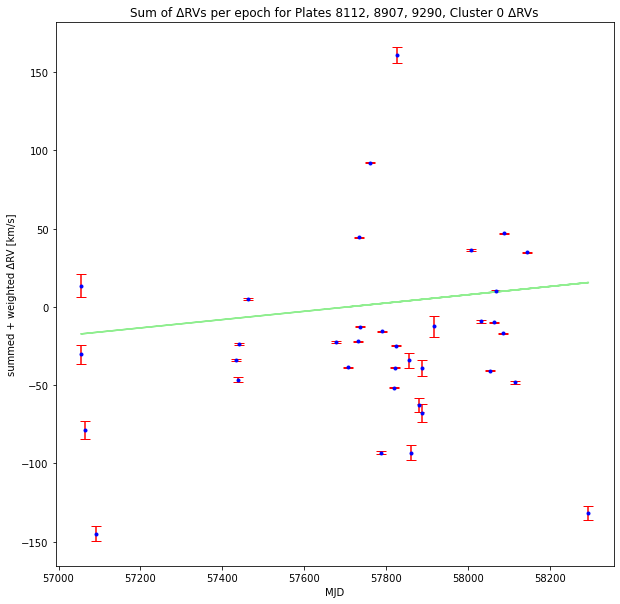

In [177]:
x_cf = weightedavg_df_cutoff['MJD']
y_cf = weightedavg_df_cutoff['Combined ΔRV (m/s)']
yerr_cf = weightedavg_df_cutoff['Combined σRV (m/s)']
weights = 1/(yerr_cf**2)
model, cov = np.polyfit(x_cf, y_cf, deg=1, w=weights, cov=True)
a, b = model

# Scatterplot of combined total ΔRVs per epoch for Plate 9290, with linear fit

plt.figure(figsize=(10, 10))
plt.errorbar(x_cf, y_cf, yerr_cf, fmt='.', color='blue', ecolor='red', capsize=5)
plt.plot(x, a*x+b, color='lightgreen')
plt.title('Sum of ΔRVs per epoch for Plates 8112, 8907, 9290, Cluster 0 ΔRVs')
plt.xlabel('MJD')
plt.ylabel('summed + weighted ΔRV [km/s]')

# Gradient - not sure how to interpret?

print('Gradient of slope:', a, '[m/MJD]')
print('Polynomial coefficients:', a, b)
print('Covariance matrix:', cov)
print('Uncertainty:', np.sqrt(np.diag(cov)))

In [ ]:
print(np.sqrt(np.diag(cov)))

In [108]:
a, b = np.polyfit(x_cf, y_cf, deg=1, w=weights)
print(np.polyfit(x_cf, y_cf, deg=1, w=weights))
print(a)
print(b)

[ 5.84682581e-02 -3.38645306e+03]
0.05846825809757231
-3386.45305865877


In [92]:
df2 = pd.concat([df0, df1])

In [93]:
df2

,Target ID,MJD,OBSVHELIO (km/s),OBSVREL Error (km/s),<RV>,ΔRV,Cluster
0,apo25m.5226.150-08-RV.2M03252400+4614203,57706,-86.565704,0.010245,-86.476541,-0.089163,0
15,apo25m.5226.150-08-RV.2M03252400+4614203,58143,-86.096080,0.019952,-86.476541,0.380461,0
14,apo25m.5226.150-08-RV.2M03252400+4614203,58114,-86.530830,0.018672,-86.476541,-0.054289,0
13,apo25m.5226.150-08-RV.2M03252400+4614203,58087,-86.532440,0.008684,-86.476541,-0.055899,0
12,apo25m.5226.150-08-RV.2M03252400+4614203,58085,-86.569565,0.009636,-86.476541,-0.093024,0
...,...,...,...,...,...,...,...
3300,apo25m.5226.150-08-RV.2M03411209+4530317,57760,-31.895340,0.349240,-32.182084,0.286744,1
3298,apo25m.5226.150-08-RV.2M03411209+4530317,57734,-33.901012,0.408702,-32.182084,-1.718928,1
3297,apo25m.5226.150-08-RV.2M03411209+4530317,57732,-34.098110,0.179040,-32.182084,-1.916026,1
3296,apo25m.5226.150-08-RV.2M03411209+4530317,57706,-32.973503,0.359694,-32.182084,-0.791419,1


<AxesSubplot:ylabel='Frequency'>

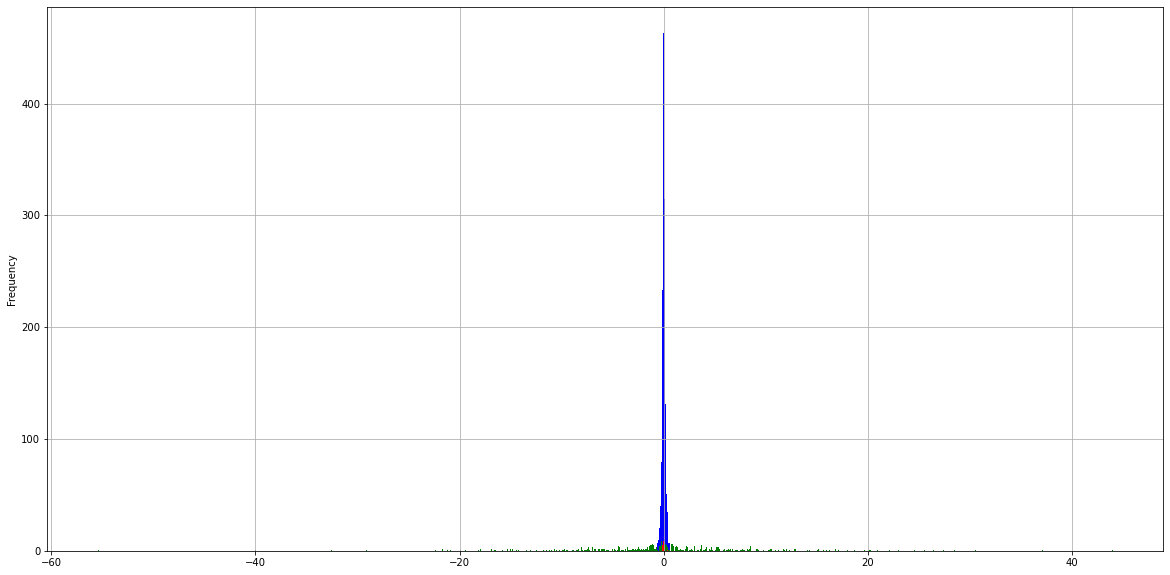

In [94]:
plt.figure(figsize=(20, 10))
df2['ΔRV'].plot.hist(grid=True, bins=2000, rwidth=1, color='b')
df1['ΔRV'].plot.hist(grid=True, bins=2000, rwidth=1, color='g')
df0['ΔRV'].plot.hist(grid=True, bins=2000, rwidth=1, color='r')
# plt.xlim(-5, 5)

In [95]:
data0 = list(df0['ΔRV'])
data1 = list(df1['ΔRV'])
data2 = data0 + data1

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([-55.42705416, -55.37734637, -55.32763859, ...,  43.88910027,
         43.93880806,  43.98851584]),
 <BarContainer object of 2000 artists>)

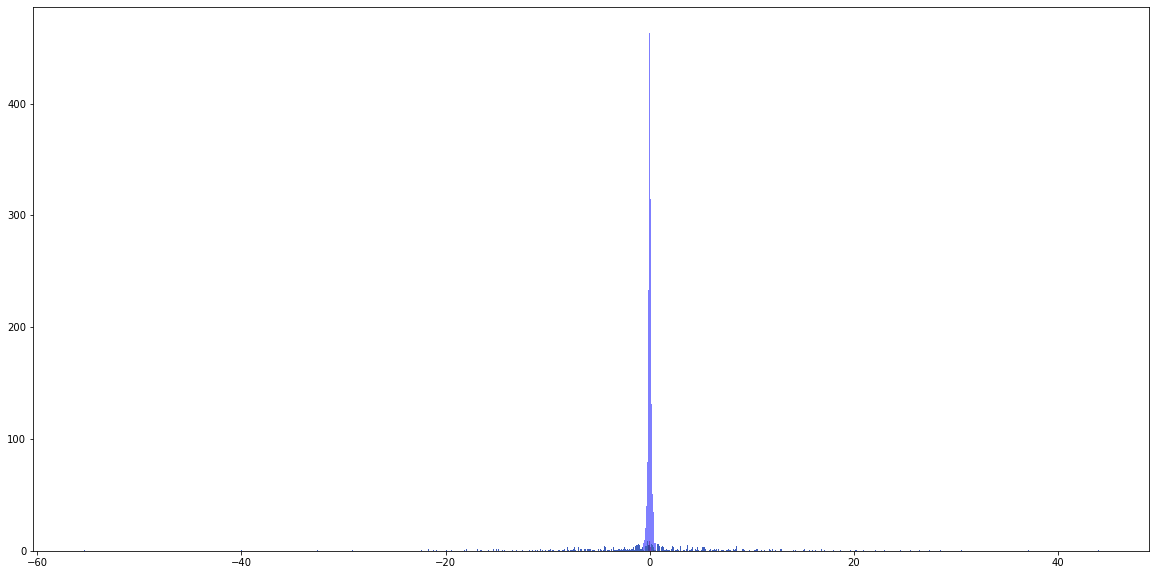

In [96]:
plt.figure(figsize=(20,10))
plt.hist(data0, bins=2000, alpha=0.5, label='cluster 0', color='r')
plt.hist(data1, bins=2000, alpha=0.5, label='cluster 0', color='g')
plt.hist(data2, bins=2000, alpha=0.5, label='cluster 0', color='b')
# plt.xlim(-20, 20)

(array([1., 0., 0., ..., 0., 0., 1.]),
 array([-55.42705416, -55.37734637, -55.32763859, ...,  43.88910027,
         43.93880806,  43.98851584]),
 <BarContainer object of 2000 artists>)

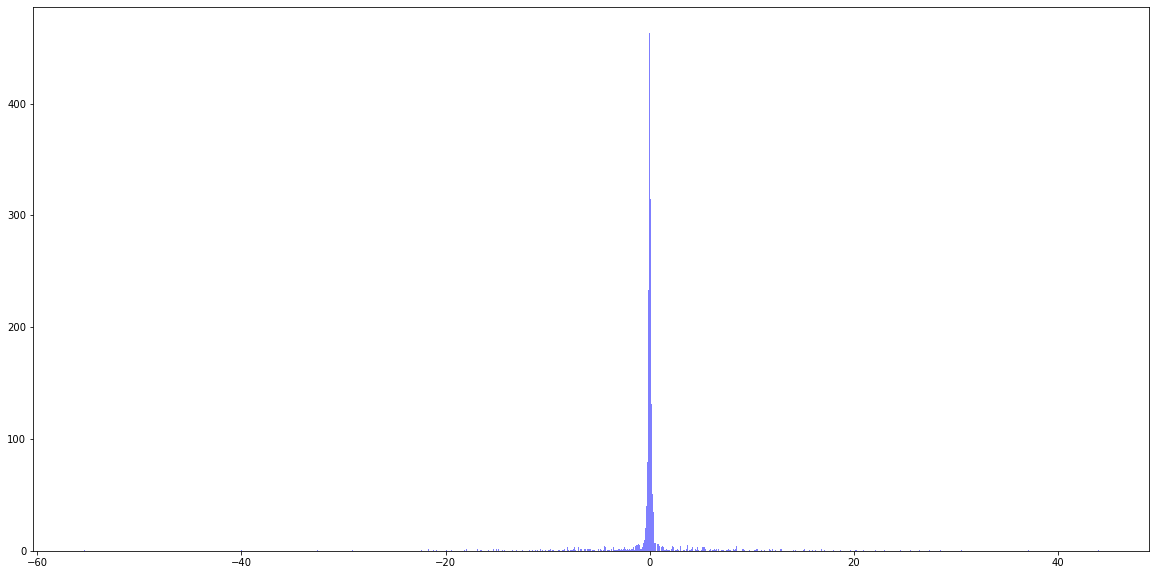

In [97]:
plt.figure(figsize=(20,10))
plt.hist(data2, bins=2000, alpha=0.5, label='cluster 0', color='b')

## Step 5
- Pick some RV standard stars (~10)
- Apply correction (50/100 m correction is large for typical statistical error of APOGEE)

## Step 6
- Try repeating this process for other plates
- Combine plots for all plates (fill in gaps in MJD)
    - Difference in N measurements per object doesn't matter bc statistical error will be larger with fewer data points, makes up for it

## Step ?
- Try PCA

In [41]:
features = ['MJD', 'ΔRV']#, 'OBSVREL Error (km/s)', '<RV>']

In [42]:
x2 = df.loc[:, features].values

In [43]:
y2 = df.loc[:, ['Target ID']].values

In [44]:
x2 = StandardScaler().fit_transform(x2)

In [45]:
x2.shape

(3408, 2)

In [46]:
# Check standard dev is 1.0

np.mean(x2), np.std(x2)

(1.9546180011006278e-18, 1.0)

In [47]:
feat_cols = ['feature'+str(i) for i in range(x2.shape[1])]

In [48]:
normalised_data = pd.DataFrame(x2,columns=feat_cols)

In [49]:
normalised_data.tail()

,feature0,feature1
3403,-1.212567,0.010070
3404,-1.370993,-0.038174
3405,1.115074,-0.005590
3406,-0.865249,0.001966
3407,1.291780,0.036056


In [50]:
pca = PCA(n_components = 2)

In [51]:
principalComponents = pca.fit_transform(x2)

In [52]:
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2'])

In [53]:
principalDf.tail()

,principal component 1,principal component 2
3403,-0.864535,0.850293
3404,-0.942445,0.996431
3405,0.792429,-0.784524
3406,-0.613213,0.610433
3407,0.887931,-0.938921


In [54]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.52070766 0.47929234]


<Figure size 432x288 with 0 Axes>

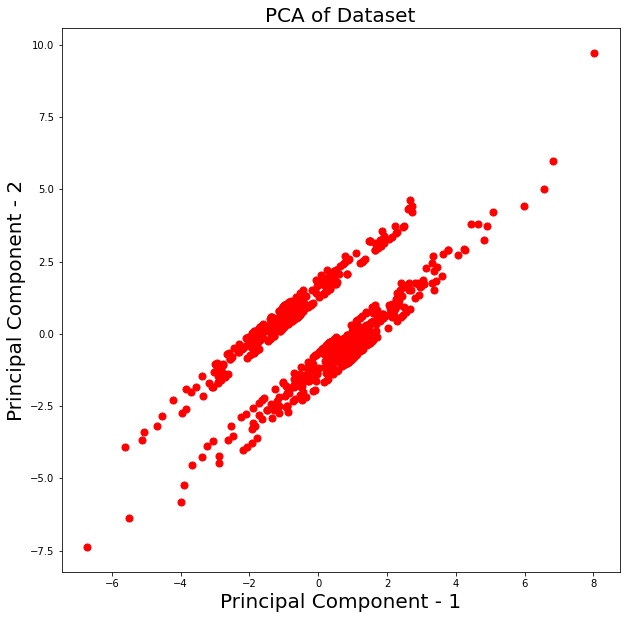

In [55]:
plt.figure()
plt.figure(figsize=(10,10))
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("PCA of Dataset",fontsize=20)
targets = [df['Target ID']]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = df['Target ID'] == target
    plt.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

# plt.legend(targets,prop={'size': 15})

In [165]:
finalDf = pd.concat([principalDf, df[['Target ID']]], axis = 1)

In [166]:
finalDf

,principal component 1,principal component 2,Target ID
0,-0.018731,-1.022855,apo25m.5226.150-08-RV.2M03252400+4614203
1,-0.025336,-0.914397,apo25m.5226.150-08-RV.2M03252400+4614203
2,-0.025844,-0.906054,apo25m.5226.150-08-RV.2M03252400+4614203
3,-0.026098,-0.901884,apo25m.5226.150-08-RV.2M03252400+4614203
4,-0.032449,-0.797598,apo25m.5226.150-08-RV.2M03252400+4614203
...,...,...,...
3627,-0.109078,0.488988,apo25m.5226.150-08-RV.2M03415658+4626067
3628,-0.113397,0.559901,apo25m.5226.150-08-RV.2M03415658+4626067
3629,-0.113905,0.568244,apo25m.5226.150-08-RV.2M03415658+4626067
3630,-0.120764,0.680872,apo25m.5226.150-08-RV.2M03415658+4626067
